# 명령 패턴으로 제어 흐름과 상태 업데이트 결합하는 방법


!!! 정보 "전제 조건"
    이 가이드는 다음에 대한 친숙함을 전제로 합니다:

    - [상태](../../concepts/low_level#state)
    - [노드](../../concepts/low_level#nodes)
    - [엣지](../../concepts/low_level#edges)
    - [명령어](../../concepts/low_level#command)

제어 흐름(엣지)과 상태 업데이트(노드)를 결합하면 유용할 수 있습니다. 예를 들어, 같은 노드에서 상태 업데이트를 수행하고 다음에 이동할 노드를 결정하고 싶을 수 있습니다. LangGraph는 노드 함수에서 `Command` 객체를 반환하여 이를 수행하는 방법을 제공합니다:

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        # 상태 업데이트
        update={"foo": "bar"},
        # 제어 흐름
        goto="my_other_node"
    )
```

[서브그래프](#subgraphs)를 사용하는 경우, 서브그래프의 노드에서 다른 서브그래프로 이동하고 싶을 수 있습니다(즉, 부모 그래프의 다른 노드). 이를 위해 `Command`에서 `graph=Command.PARENT`를 지정할 수 있습니다:

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        update={"foo": "bar"},
        goto="other_subgraph",  # 여기서 `other_subgraph`는 부모 그래프의 노드입니다
        graph=Command.PARENT
    )
```

!!! 중요 "State 업데이트와 `Command.PARENT`"

    서브그래프 노드에서 부모 그래프 노드로 전송할 때, 부모 그래프와 서브그래프의 [상태 스키마](../../concepts/low_level#schema)에서 공유된 키에 대한 업데이트를 보낼 경우, 부모 그래프 상태에서 업데이트할 키에 대해 **반드시** [리듀서](../../concepts/low_level#reducers)를 정의해야 합니다. 아래의 [예시](#navigating-to-a-node-in-a-parent-graph)를 참조하세요.

이 가이드는 LangGraph 앱에서 동적인 제어 흐름을 추가하기 위해 `Command`를 사용하는 방법을 보여줍니다.


## 설정

먼저 필요한 패키지를 설치합시다.


In [1]:
%%capture --no-stderr
%pip install -U langgraph


<div class="admonition tip">
    <p class="admonition-title">LangGraph 개발을 위해 <a href="https://smith.langchain.com">LangSmith</a> 설정하기</p>
    <p style="padding-top: 5px;">
        LangSmith에 가입하여 LangGraph 프로젝트의 문제를 신속하게 파악하고 성능을 향상시키세요. LangSmith를 사용하면 trace 데이터를 통해 LangGraph로 구축한 LLM 앱을 디버그하고 테스트하며 모니터링할 수 있습니다 — 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">여기</a>를 읽어보세요.
    </p>
</div>


A, B, C의 3개 노드로 간단한 그래프를 만들어 봅시다. 먼저 노드 A를 실행한 후, 노드 A의 출력에 따라 노드 B 또는 노드 C로 이동할지를 결정합니다.


## 기본 사용법


In [2]:
import random
from typing_extensions import TypedDict, Literal

from langgraph.graph import StateGraph, START
from langgraph.types import Command


# Define graph state
class State(TypedDict):
    foo: str


# Define the nodes


def node_a(state: State) -> Command[Literal["node_b", "node_c"]]:
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )


def node_b(state: State):
    print("Called B")
    return {"foo": state["foo"] + "b"}


def node_c(state: State):
    print("Called C")
    return {"foo": state["foo"] + "c"}


이제 위의 노드들로 `StateGraph`를 생성할 수 있습니다. 그래프에 라우팅을 위한 [조건부 엣지](../../concepts/low_level#conditional-edges)가 없다는 점에 주목하세요! 이는 제어 흐름이 `node_a` 내부의 `Command`로 정의되기 때문입니다.


In [3]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(node_b)
builder.add_node(node_c)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()


!!! 중요

    여러분은 `Command`를 반환 타입 주석으로 사용했다는 것을 알아차렸을 것입니다. 예를 들어, `Command[Literal["node_b", "node_c"]]`와 같이 말이죠. 이는 그래프 렌더링에 필요하며 LangGraph에 `node_a`가 `node_b`와 `node_c`로 이동할 수 있음을 알려줍니다.


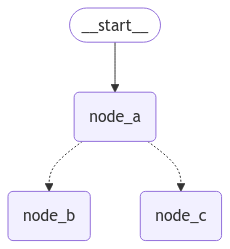

In [4]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


그래프를 여러 번 실행하면 노드 A의 랜덤 선택에 따라 서로 다른 경로(A -> B 또는 A -> C)를 선택하는 것을 볼 수 있습니다.


In [5]:
graph.invoke({"foo": ""})


Called A
Called C


{'foo': 'bc'}

## 부모 그래프에서 노드로 이동하기


이제 하위 그래프 내부에서 부모 그래프의 다른 노드로 이동하는 방법을 시연하겠습니다. 위의 예에서 `node_a`를 단일 노드 그래프로 변경하여 이를 부모 그래프에 하위 그래프로 추가하겠습니다.


!!! 중요 "상태 업데이트 `Command.PARENT` 사용"

    서브그래프 노드에서 부모 그래프 노드로 업데이트를 보낼 때 부모와 서브그래프 [상태 스키마](../../concepts/low_level#schema)에서 공유되는 키에 대해, 부모 그래프 상태에서 업데이트하는 키에 대한 [리듀서](../../concepts/low_level#reducers)를 **반드시** 정의해야 합니다.


In [6]:
import operator
from typing_extensions import Annotated


class State(TypedDict):
    # NOTE: we define a reducer here
    # highlight-next-line
    foo: Annotated[str, operator.add]


def node_a(state: State):
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"foo": value},
        goto=goto,
        # this tells LangGraph to navigate to node_b or node_c in the parent graph
        # NOTE: this will navigate to the closest parent graph relative to the subgraph
        # highlight-next-line
        graph=Command.PARENT,
    )


subgraph = StateGraph(State).add_node(node_a).add_edge(START, "node_a").compile()


def node_b(state: State):
    print("Called B")
    # NOTE: since we've defined a reducer, we don't need to manually append
    # new characters to existing 'foo' value. instead, reducer will append these
    # automatically (via operator.add)
    # highlight-next-line
    return {"foo": "b"}


def node_c(state: State):
    print("Called C")
    # highlight-next-line
    return {"foo": "c"}


In [7]:
builder = StateGraph(State)
builder.add_edge(START, "subgraph")
builder.add_node("subgraph", subgraph)
builder.add_node(node_b)
builder.add_node(node_c)

graph = builder.compile()


In [8]:
graph.invoke({"foo": ""})


Called A
Called C


{'foo': 'bc'}